# homework 10: the adventure of the moonlighting genes
Yining Hua

In [180]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import random

np.random.seed(42)
random.seed(42)

### Q1. write a function that simulates positive control data
Using the generative model assumed by NMF, write a function that generates synthetic data for N genes and M experiments, generated from R underlying gene batteries.

Visualize your gene battery assignments to demonstrate that your function generates reasonable data.

In [181]:
N, M, R = 100, 60, 5 # N genes, M experiments, R modules
n_moonlight = random.randint(2,5)
C_min, C_max = 90000, 110000
n_moonlight

2

In [182]:
def generate_simulated_data(N, M, R):
    moonlight_genes = [np.random.choice(N) for i in range(n_moonlight)] 
    W = np.zeros((N, R))
    for i in range(N):
        k = np.random.choice(R)
        W[i][k]= 1
        if i in moonlight_genes:
            if (k-1) in range(R):
                W[i][k-1] =1 
            else: W[i][k+1] =1
    ## normalization
    col_sum = np.sum(W,axis=0)
    for i in range(N):
        W[i][:] = W[i][:]/col_sum

    H = np.random.dirichlet(np.ones(R),M).T
    C = np.random.choice(range(C_min,C_max),M)
    V_exp = C*(W@H)
    
    V_true = V_exp + np.random.poisson(V_exp)    ## here's where the poisson comes in

    return V_true, V_exp, W, H

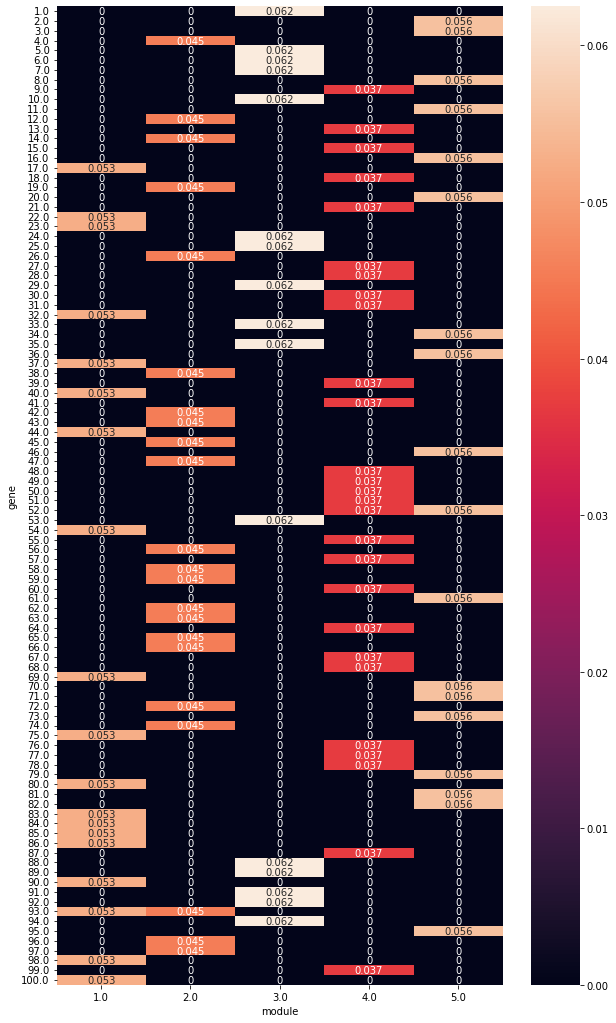

In [183]:
V_true, V_exp, W, H= generate_simulated_data(N, M ,R)

plt.figure(figsize=(10,18))
rows = np.linspace(1,N,N)
sns.heatmap(W, xticklabels = np.linspace(1,R,R), yticklabels = np.linspace(1,N,N), annot=True)
plt.xlabel('module')
plt.ylabel("gene")
plt.show()

So I pretty much generated some reasonable data. We see that each module has some genes, genes in each module habe the same value, and there are the same number (n=2) of moonlight genes as we randint() in the first chunk of this section: gene 52 and 93

### Q2. implement nonnegative matrix factorization
Implement NMF, following the description in [Lee and Seung (1999)]. Explain your steps.

In [184]:
def update_WH(V_true, V_exp, C, W, H):
    W_new = W*(((V_true*C)/V_exp)@H.T)
    W_new = W_new/np.sum(W_new, axis = 0)  ## normalization
    H_new = H*(W.T@(V_true/V_exp))
    return W_new, H_new

In [185]:
threshold = 0.01
def NMF(V_true, R):
    ## Random initialization
    W, H = np.random.dirichlet(np.ones(N),R).T, np.random.dirichlet(np.ones(R),M).T
    ## calc values
    C = np.sum(V_true,axis = 0)  
    V_exp = C*(W@H)
    
    ll = float('inf')      ## initial values be large
    ll_diff = float('inf')
    ll_list = []
    while ll_diff > threshold:    ## while not meet our threshold standard, update
        W, H = update_WH(V_true, V_exp, C, W, H)
        V_exp = C*(W@H)
        ll_new = np.sum(V_true*np.log(V_exp) - V_exp)  # log likelihood
        ll_list.append(ll_new)
        ll_diff = abs(ll_new - ll)
        ll = ll_new
    
    return W, H, ll_list

### 3. test your implementation
Apply your NMF function to synthetic datasets that you generate, varying the parameters of your synthetic data. What conclusions can you draw about how well NMF reconstructs the known gene batteries in your synthetic data? Explain your findings.

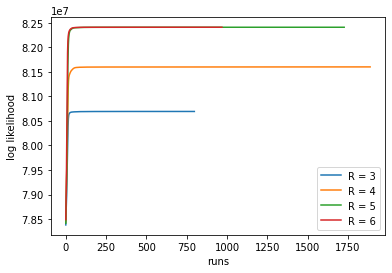

In [186]:
## R from 3 to 6
convergence = []
Ws = []
for R in range(3,7):
    W,H,ll_list= NMF(V_true, R)
    plt.plot(ll_list,label = f"R = {R}")
    convergence.append(ll_list[-1])
    Ws.append(W)
plt.xlabel("runs")
plt.ylabel("log likelihood")
plt.legend()

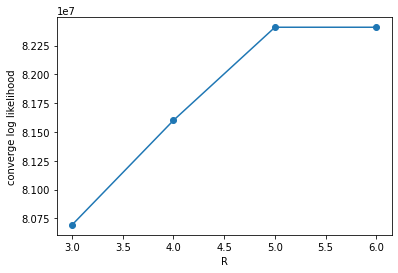

In [187]:
plt.xlabel("R")
plt.ylabel("converge log likelihood")
plt.plot(range(3,7), convergence, marker = "o")

There are probably 5 gene batteries in the data I generated. You can see in the plot of where the NMF model stopped, the llh stopped changing after R=5. Also in the LLH vs. #runs figure we can see that the LLH for R=5 and R=6 are almost the same (at the same level), while R=3 and R=4 are at two different levels (also different from R=5 and R=6, giant gaps)

### Q4. analyze the Adler data
Apply your NMF analysis to the Adler dataset.

- What is your best guess for how many gene batteries (NMF clusters) there are, and why? (Your choices are 3..6.)

- How many genes are in each battery, and what are they?

- How many moonlighting genes are there, and what are they?

In [70]:
data = pd.read_table('w10-data.tbl.txt', delim_whitespace=True, header=None, index_col=0)
data

,1,2,3,4,5,6,7,8,9,10,...,51,52,53,54,55,56,57,58,59,60
0,,,,,,,,,,,,,,,,,,,,,
anise,897,24,129,269,43,1296,271,26,835,461,...,48,151,41,252,622,704,933,708,771,121
apricot,174,3,26,54,17,258,84,8,195,103,...,15,26,6,66,155,172,178,150,153,27
artichoke,842,3444,4036,1119,5814,2268,7005,3633,2863,355,...,20,8081,1374,1928,3728,1754,1158,2876,834,3088
arugula,3160,2495,7246,9751,2775,382,395,9203,3561,8141,...,8915,3983,9404,2158,2474,2728,1657,2242,5662,2315
asparagus,567,14,93,157,40,815,188,16,511,277,...,31,99,18,165,440,462,603,416,476,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wasabi,46,110,1,12,83,3,36,32,10,13,...,70,6,59,129,1,63,30,39,16,133
watercress,286,644,11,82,423,15,288,162,88,71,...,389,16,356,641,28,365,156,237,129,780
watermelon,205,737,922,235,1267,524,1579,847,656,86,...,5,1826,288,462,820,405,255,699,171,732


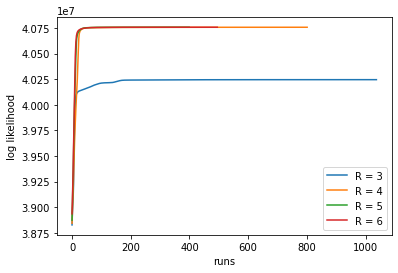

In [140]:
V = data.to_numpy()

convergence = []
for R in range(3,7):
    W, H, ll = NMF(V, R)
    convergence.append(ll[-1])
    plt.plot(ll, label=f"R = {R}")
    plt.xlabel("runs")
    plt.ylabel("log likelihood")
    plt.legend()

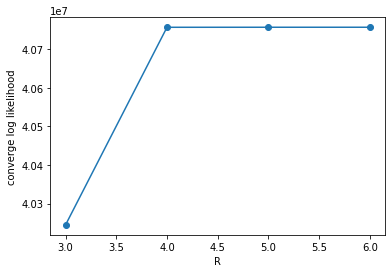

In [141]:
plt.xlabel("R")
plt.ylabel("converge log likelihood")
plt.plot(range(3,7),convergence, marker = "o")

So the best guess for # gene batteries is 4 (we see that it stopped converge at R=4)

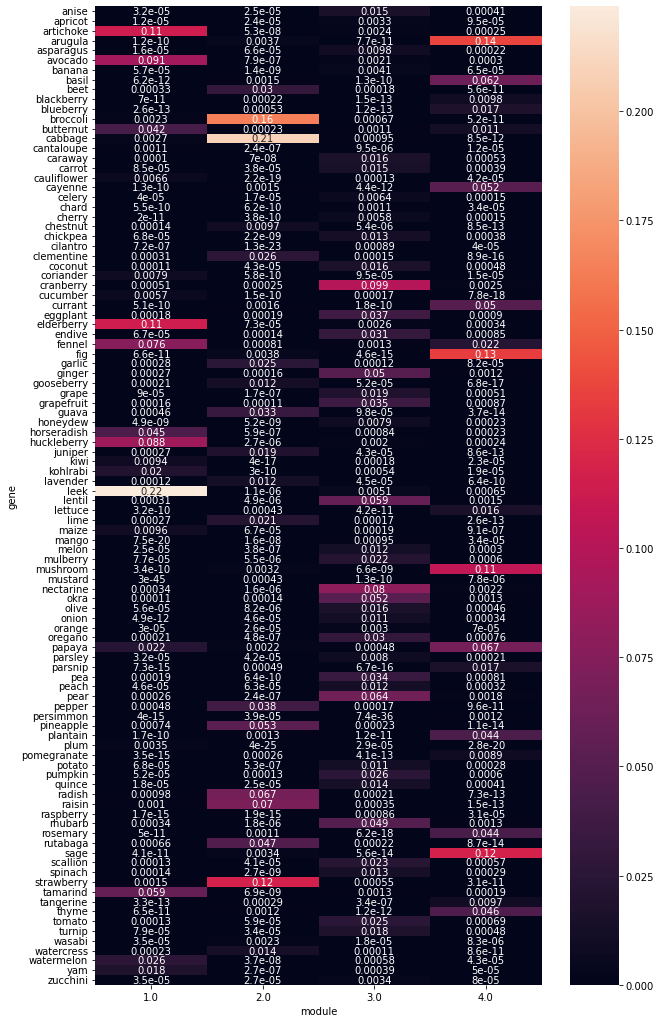

In [142]:
R = 4 ## best guess
W, H, ll = NMF(V, R)
plt.figure(figsize=(10,18))
sns.heatmap(W, xticklabels =np.linspace(1,R,R) , yticklabels = data.index, annot=True)
plt.xlabel('module')
plt.ylabel("gene")
plt.show()

Let's normalize the matrix and find a threshold to convert it into a binary matrix where 0 represents "not present" and 1 represents "present", so we can view the heatmap better

Text(0, 0.5, 'Frequency')

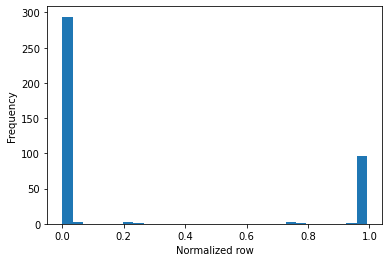

In [144]:
from sklearn.preprocessing import normalize
W = normalize(W, axis=1, norm='l1')   ## Normalize the matrix by columns

plt.hist(W.flatten(), bins=30)
plt.xlabel('Normalized row')
plt.ylabel('Frequency')

Guess we are safe to set the threshold at 0.1

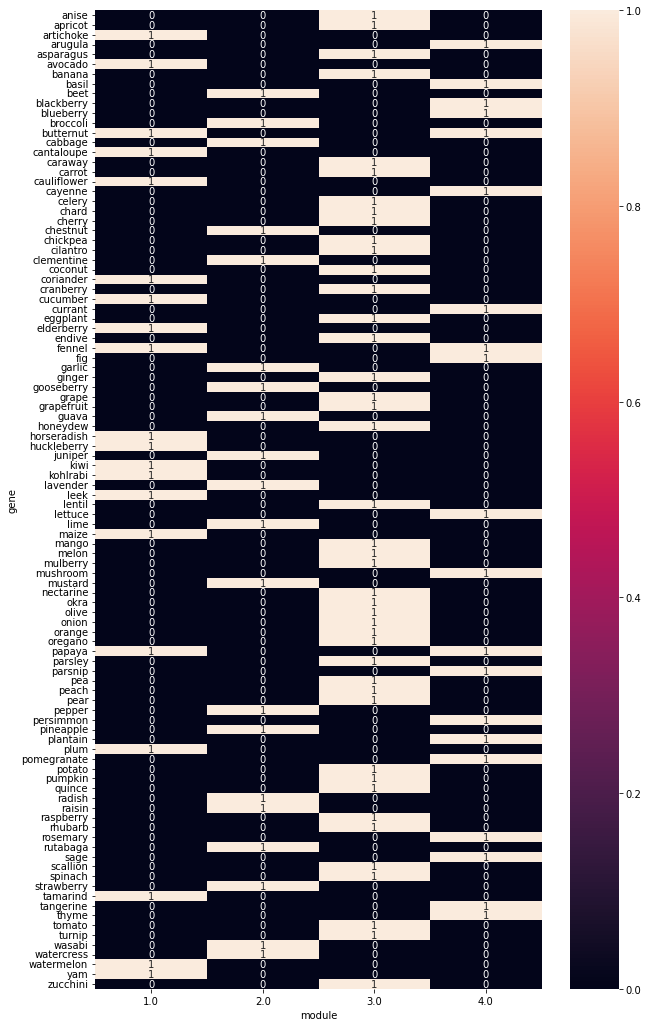

In [145]:
threshold = 0.1
Wb = np.where(W > threshold, 1, 0)

plt.figure(figsize=(10,18))
sns.heatmap(Wb, xticklabels =np.linspace(1,R,R) , yticklabels = data.index, annot=True)
plt.xlabel('module')
plt.ylabel("gene")
plt.show()

Better now. Printing the names

In [147]:
gene = data.index
b1, b2, b3, b4 = [], [], [], []
for i in range(N):
    if Wb[i][0]>= 1:
        b1.append(gene[i])
    if Wb[i][1]>=1:
        b2.append(gene[i])
    if Wb[i][2]>=1:
        b3.append(gene[i])
    if Wb[i][3]>=1:
        b4.append(gene[i])
print("%i genes are in gene battery 1: %s\n"%(len(b1),", ".join(b1)))
print("%i genes are in gene battery 2: %s\n"%(len(b2),", ".join(b2)))
print("%i genes are in gene battery 3: %s\n"%(len(b3),", ".join(b3)))
print("%i genes are in gene battery 4: %s\n"%(len(b4),", ".join(b4)))

20 genes are in gene battery 1: artichoke, avocado, butternut, cantaloupe, cauliflower, coriander, cucumber, elderberry, fennel, horseradish, huckleberry, kiwi, kohlrabi, leek, maize, papaya, plum, tamarind, watermelon, yam

20 genes are in gene battery 2: beet, broccoli, cabbage, chestnut, clementine, garlic, gooseberry, guava, juniper, lavender, lime, mustard, pepper, pineapple, radish, raisin, rutabaga, strawberry, wasabi, watercress

43 genes are in gene battery 3: anise, apricot, asparagus, banana, caraway, carrot, celery, chard, cherry, chickpea, cilantro, coconut, cranberry, eggplant, endive, ginger, grape, grapefruit, honeydew, lentil, mango, melon, mulberry, nectarine, okra, olive, onion, orange, oregano, parsley, pea, peach, pear, potato, pumpkin, quince, raspberry, rhubarb, scallion, spinach, tomato, turnip, zucchini

20 genes are in gene battery 4: arugula, basil, blackberry, blueberry, butternut, cayenne, currant, fennel, fig, lettuce, mushroom, papaya, parsnip, persimmon,

In [149]:
moonlight_genes = []
for i in range(N):
    if np.sum(Wb[i][:])>1:
        moonlight_genes.append(gene[i])
print("%i genes are moonlight genes 1: %s"%(len(moonlight_genes), ", ".join(moonlight_genes)))

3 genes are moonlight genes 1: butternut, fennel, papaya
